In [1]:
import pints
import pints.toy as toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import edward as ed
from edward.models import Normal

ed.set_seed(42)

Instructions for updating:
Use the retry module or similar alternatives.


## Formulating Problem

In [2]:
# Create a model
model = pints.toy.LogisticModel()

n_parameters = model.n_parameters()
n_outputs = model.n_outputs()
real_parameters = [0.15, 500]

values, times, noise = emutils.simulate(model,
                                        parameters = real_parameters)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

print("Number of parameters: ", n_parameters)
print("Parameter values: ", real_parameters)
print("Example problem values:\n", problem.values()[:5])

Number of parameters:  2
Parameter values:  [0.15, 500]
Example problem values:
 [14.36723662 -0.73010642 19.80292564 42.90095131  0.91011587]


## Creating and normalizing training data

In [3]:
# creating distribution on bounds
real_params_lower = [0.1, 400]
real_params_upper = [0.2, 600]

bounds = pints.RectangularBoundaries(lower = real_params_lower, upper = real_params_upper)
log_prior = pints.UniformLogPrior(bounds)

In [4]:
# make training sample
train_size = 5000
train_input = log_prior.sample(train_size)
train_target = np.apply_along_axis(real_log_likelihood, 1, train_input)

In [5]:
# normalize data between -0.5 and 0.5
def normalize(x):
    mean, std = np.mean(x, axis=0), np.std(x, axis=0)
    return (x - mean) / std

def denormalize(y, mean, std):
    return y * std + mean
    
train_input_normalized = normalize(train_input)
train_target_normalized = normalize(train_target)

# define functions for future use
train_input_mean = np.mean(train_input, axis=0)
train_input_std = np.std(train_input, axis=0)

train_target_mean = np.mean(train_target, axis=0)
train_target_std = np.std(train_target, axis=0)

def normalize_input(x):
    return (x - train_input_mean) / train_input_std

def denormalize_prediction(x_norm):
    return denormalize(x_norm, train_target_mean, train_target_std)

In [6]:
train_target_mean

-429.1392991839331

# Bayesian NN

In [46]:
tf.Session().run(tf.sqrt())

0.6324555

In [7]:
# network parameters
bnn_shape = [n_parameters, 5, 5, 1]
activations = tf.nn.relu

# variational inference parameters
n_iter=2000
n_samples=10

In [47]:
class BNNEmulator(emupints.Emulator):
    
    def __init__(self, log_likelihood, X, y, **kwargs):
        super(BNNEmulator, self).__init__(log_likelihood, X, y, **kwargs)
        
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)

        
    def __call__(self, x):
        # convert to np array
        if type(x) != np.ndarray:
            x = np.asarray(x)
        # reshape input to fit placeholder
        n_params = self.n_parameters()
        x = x.reshape((x.size // n_params, n_params))
        
        feed_dict = {self._x : x}
        
        ans = self.sess.run(self._nns, feed_dict=feed_dict)

        # for call return an average of predictions
        return np.mean(ans)


    def predict(self, x):
        # convert to np array
        if type(x) != np.ndarray:
            x = np.asarray(x)
        n_params = self.n_parameters()
        x = x.reshape((x.size // n_params, n_params))

        feed_dict = {self._x : x}
        
        # TODO: compare different ways of sampling posterior
        sample = self._nns.eval(feed_dict=feed_dict)
        return np.mean(sample), np.std(sample)
    

    def set_parameters(self, shape, activations=tf.tanh, posterior_n_samples = 10):
        # if only one activation function provided make list
        if not hasattr(activations, '__len__'):
            activations = [activations] * (len(shape) - 2)
            activations.append(tf.identity)

        self._activations = activations
            
        self.shape = shape
        
        self._weights = []
        self._biases = []
        self._q_weights = []
        self._q_biases = []
        
        self._qp_dict = {}
        
        with self.graph.as_default():
            with self.sess.as_default() as sess:
                # define variables
                for i in range(len(shape)-1):
                    # initialize weights for layer i with mean 0 and variance sqrt(2/shape[i])
                    W_i = Normal(loc=tf.zeros([shape[i], shape[i+1]]), 
                                 scale= tf.sqrt(2 / shape[i]),
                                 name='W_' + str(i),
                                )
                    b_i = Normal(loc=tf.zeros(shape[i+1]), 
                                 scale=tf.ones(shape[i+1]),
                                 name='b_' + str(i),
                                )
                    with tf.variable_scope("qW_" + str(i)):
                        loc = tf.get_variable("loc", [shape[i], shape[i+1]])
                        scale = tf.nn.softplus(tf.get_variable("scale", [shape[i], shape[i+1]]))
                        qW_i = Normal(loc=loc, scale=scale)

                    with tf.variable_scope("qb_" + str(i)):
                        loc = tf.get_variable("loc", [shape[i+1]])
                        scale = tf.nn.softplus(tf.get_variable("scale", [shape[i+1]]))
                        qb_i = Normal(loc=loc, scale=scale)

                    # store created variables in list
                    self._weights.append(W_i)
                    self._biases.append(b_i)
                    self._q_weights.append(qW_i)
                    self._q_biases.append(qb_i)
                    # relate variables to their approximations
                    self._qp_dict[W_i] = qW_i
                    self._qp_dict[b_i] = qb_i

                # make graph
                self._x = tf.placeholder(tf.float32, shape=(None, self.n_parameters()))

                self._z = Normal(
                    loc=self._make_nn(self._weights, self._biases, self._activations),
                    scale=0.1 * tf.ones(tf.shape(self._x)[0]),
                    name="z"
                )

            # sample weights and biases from approximated weights to make NNs
            nns = []
            for _ in range(posterior_n_samples):
                qweights_sample = [
                    qW.sample() for qW in self._q_weights
                ]
                qbiases_sample = [
                    qb.sample() for qb in self._q_biases
                ]
                nns.append(self._make_nn(qweights_sample,
                                         qbiases_sample, 
                                         self._activations))
            # eval _nns for prediction
            self._nns = tf.stack(nns)

    #np.sqrt(2 / layers_dims[l-1])


    # performs variational inference 
    def fit(self, n_iter=1000, n_samples=5, learning_rate=None):        
        # data for input and target
        data = {
            self._x : self._X,
            self._z : self._y.reshape(-1)
        }
        
        with self.graph.as_default():
            with self.sess.as_default() as sess:
                init = tf.global_variables_initializer()
                sess.run(init)
                # infer parameters through variational inference
                inference = ed.KLqp(self._qp_dict, data=data)
                inference.run(n_iter=n_iter, n_print=10, n_samples=n_samples, logdir='log')
                # for debugging
                self._inference = inference

            
    def _make_nn(self, weights, biases, activations):
        W_0, b_0, a_0 = weights[0], biases[0], activations[0]

        h = a_0(tf.matmul(self._x, W_0) + b_0)
        for W_i, b_i, a_i in zip(weights[1:], biases[1:], activations[1:]):
            h = a_i(tf.matmul(h, W_i) + b_i)
            
        return tf.reshape(h, [-1])
    
    def __str__():
        pass

In [48]:
# create emulator for this instance
emu_nn = BNNEmulator(real_log_likelihood, train_input_normalized, train_target_normalized)

In [49]:
# specify shape of NN
emu_nn.set_parameters(bnn_shape, activations=activations)

In [51]:
emu_nn.fit(n_iter=n_iter, n_samples=n_samples)

2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 3820.219


In [52]:
emu_nn_normalized = lambda x: denormalize_prediction(emu_nn(normalize_input(x)))

In [53]:
emu_nn_normalized([0.15, 500])

-211.36804688780649

# Performance test

In [54]:
def mean_error(y_pred, y_true):
    return np.mean(np.abs(y_true - y_pred))

In [55]:
# look at mean error
test_size = 200
test_input = log_prior.sample(test_size)

test_true = np.apply_along_axis(real_log_likelihood, 1, test_input)
test_pred = emu_nn_normalized(test_input)

print("Mean error:", mean_error(test_pred, test_true))

Mean error: 127.90101386756707


In [56]:
# generate data for surfaces
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = emutils.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

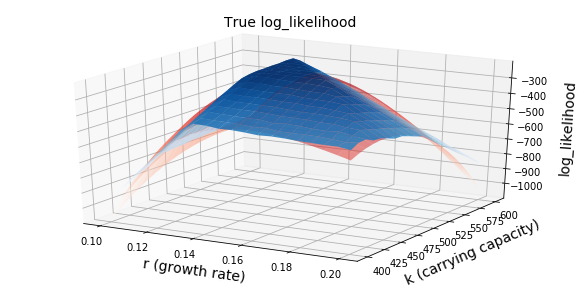

In [57]:
emulator_grid = emutils.predict_grid(emu_nn_normalized, test_data)
real_grid = emutils.predict_grid(real_log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = emuplt.surface(r_grid, k_grid, emulator_grid, 
                    title = "True log_likelihood",
                    alpha = 0.9,
                    cmap="Blues",
                    x_label = "r (growth rate)",
                    y_label = "k (carrying capacity)"
                   )

ax.plot_surface(r_grid, k_grid, real_grid, cmap="Reds", alpha = .5)

In [58]:
emu_nn_normalized([0.140, 400])

-397.17663439016417

In [19]:
%timeit real_log_likelihood([0.15, 500])
%timeit emu_nn([0.15, 500])

22.2 µs ± 745 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
909 µs ± 9.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Performing MCMC

In [20]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(emu_nn, log_prior)
real_log_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [21]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]
xs

[array([1.35e-01, 4.50e+02]),
 array([1.575e-01, 5.250e+02]),
 array([1.725e-01, 5.750e+02])]

In [29]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.0
2     9      0         0.333     0.333      0:00.0
3     12     0.25      0.25      0.25       0:00.0
20    63     0.0952    0.0952    0.0952     0:00.1
40    123    0.0488    0.0732    0.0488     0:00.1
60    183    0.0328    0.0492    0.0328     0:00.1
80    243    0.037     0.037     0.0247     0:00.2
100   303    0.0396    0.0297    0.0297     0:00.2
120   363    0.0331    0.0248    0.0248     0:00.3
140   423    0.0284    0.0213    0.0213     0:00.3
160   483    0.0248    0.0186    0.0186     0:00.4
180   543    0.0221    0.0166    0.0166     0:00.4
Initial phase completed.
200   603    0.0199    0.0199    0.0149     0:00.4
220   663    0.0226    0.0226    0.0181     0:00.5
240   723    0.0207    0.0249    0.0207     0:00.6
260   783    0.0192    0.023

3160  9483   0.00221   0.00348   0.0019     0:10.1
3180  9543   0.0022    0.00346   0.00189    0:10.2
3200  9603   0.00219   0.00344   0.00187    0:10.2
3220  9663   0.00217   0.00342   0.00186    0:10.3
3240  9723   0.00216   0.00339   0.00185    0:10.4
3260  9783   0.00215   0.00337   0.00184    0:10.4
3280  9843   0.00213   0.00335   0.00183    0:10.5
3300  9903   0.00212   0.00333   0.00182    0:10.6
3320  9963   0.00211   0.00331   0.00181    0:10.6
3340  10023  0.0021    0.00329   0.0018     0:10.7
3360  10083  0.00208   0.00327   0.00179    0:10.7
3380  10143  0.00207   0.00325   0.00177    0:10.8
3400  10203  0.00206   0.00323   0.00176    0:10.9
3420  10263  0.00205   0.00322   0.00175    0:10.9
3440  10323  0.00203   0.0032    0.00174    0:11.0
3460  10383  0.00202   0.00318   0.00173    0:11.1
3480  10443  0.00201   0.00316   0.00172    0:11.1
3500  10503  0.002     0.00314   0.00171    0:11.2
3520  10563  0.00199   0.00312   0.0017     0:11.3
3540  10623  0.00198   0.00311 

6440  19323  0.00124   0.00171   0.000932   0:20.5
6460  19383  0.00124   0.0017    0.000929   0:20.6
6480  19443  0.00123   0.0017    0.000926   0:20.7
6500  19503  0.00123   0.00169   0.000923   0:20.7
6520  19563  0.00123   0.00169   0.00092    0:20.8
6540  19623  0.00122   0.00168   0.000917   0:20.9
6560  19683  0.00122   0.00168   0.000914   0:20.9
6580  19743  0.00122   0.00167   0.000912   0:21.0
6600  19803  0.00121   0.00167   0.000909   0:21.1
6620  19863  0.00121   0.00166   0.000906   0:21.1
6640  19923  0.0012    0.00166   0.000903   0:21.2
6660  19983  0.0012    0.00165   0.000901   0:21.2
6680  20043  0.0012    0.00165   0.000898   0:21.3
6700  20103  0.00119   0.00164   0.000895   0:21.4
6720  20163  0.00119   0.00164   0.000893   0:21.4
6740  20223  0.00119   0.00163   0.00089    0:21.5
6760  20283  0.00118   0.00163   0.000887   0:21.6
6780  20343  0.00118   0.00162   0.000885   0:21.6
6800  20403  0.00118   0.00162   0.000882   0:21.7
6820  20463  0.00117   0.00161 

9660  28983  0.000932  0.00114   0.000725   0:31.7
9680  29043  0.00093   0.00114   0.000723   0:31.7
9700  29103  0.000928  0.00113   0.000722   0:31.8
9720  29163  0.000926  0.00113   0.00072    0:31.9
9740  29223  0.000924  0.00113   0.000719   0:31.9
9760  29283  0.000922  0.00113   0.000717   0:32.0
9780  29343  0.00092   0.00112   0.000716   0:32.1
9800  29403  0.000918  0.00112   0.000714   0:32.1
9820  29463  0.000916  0.00112   0.000713   0:32.2
9840  29523  0.000915  0.00112   0.000711   0:32.3
9860  29583  0.000913  0.00112   0.00071    0:32.3
9880  29643  0.000911  0.00111   0.000708   0:32.4
9900  29703  0.000909  0.00111   0.000707   0:32.5
9920  29763  0.000907  0.00111   0.000706   0:32.5
9940  29823  0.000905  0.00111   0.000704   0:32.6
9960  29883  0.000904  0.0011    0.000703   0:32.7
9980  29943  0.000902  0.0011    0.000701   0:32.8
10000 30000  0.0009    0.0011    0.0007     0:32.8
Halting: Maximum number of iterations (10000) reached.


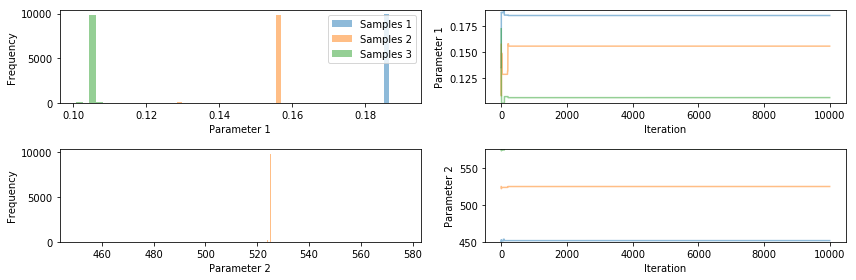

In [30]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [31]:
chains = pints.mcmc_sample(real_log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.0
2     9      0.333     0.333     0.333      0:00.0
3     12     0.25      0.25      0.25       0:00.0
20    63     0.0952    0.0476    0.19       0:00.0
40    123    0.0732    0.0732    0.122      0:00.0
60    183    0.082     0.0656    0.0984     0:00.0
80    243    0.0864    0.0494    0.0864     0:00.1
100   303    0.0693    0.0396    0.109      0:00.1
120   363    0.0579    0.0331    0.0992     0:00.1
140   423    0.0567    0.0284    0.0922     0:00.1
160   483    0.0745    0.0373    0.0807     0:00.1
180   543    0.0773    0.0387    0.0829     0:00.1
Initial phase completed.
200   603    0.0746    0.0348    0.0746     0:00.1
220   663    0.109     0.0633    0.0995     0:00.2
240   723    0.124     0.108     0.137      0:00.2
260   783    0.153     0.126

3320  9963   0.22      0.223     0.233      0:02.1
3340  10023  0.22      0.223     0.233463   0:02.2
3360  10083  0.22      0.223     0.234      0:02.2
3380  10143  0.221     0.223     0.233      0:02.2
3400  10203  0.221     0.224     0.233      0:02.2
3420  10263  0.221     0.223     0.233      0:02.2
3440  10323  0.222     0.223     0.232      0:02.2
3460  10383  0.222     0.223     0.232      0:02.2
3480  10443  0.221     0.224     0.232979   0:02.3
3500  10503  0.22      0.224     0.232505   0:02.3
3520  10563  0.22      0.223232  0.233      0:02.3
3540  10623  0.22      0.223948  0.232      0:02.3
3560  10683  0.22      0.223     0.231      0:02.3
3580  10743  0.221     0.223     0.232      0:02.3
3600  10803  0.22      0.223549  0.232      0:02.3
3620  10863  0.22      0.225     0.233      0:02.3
3640  10923  0.22      0.225     0.233      0:02.4
3660  10983  0.219     0.225     0.232      0:02.4
3680  11043  0.218     0.225     0.232      0:02.4
3700  11103  0.219     0.225   

6720  20163  0.23      0.229     0.23       0:04.3
6740  20223  0.23      0.229     0.23       0:04.3
6760  20283  0.23      0.229     0.23       0:04.3
6780  20343  0.23      0.229     0.23       0:04.3
6800  20403  0.231     0.23      0.23       0:04.3
6820  20463  0.23      0.23      0.23       0:04.4
6840  20523  0.229791  0.229791  0.23       0:04.4
6860  20583  0.23      0.23      0.229      0:04.4
6880  20643  0.23      0.23      0.229      0:04.4
6900  20703  0.23      0.229387  0.23       0:04.4
6920  20763  0.23      0.229     0.23       0:04.4
6940  20823  0.229938  0.229     0.229938   0:04.4
6960  20883  0.23      0.229     0.23       0:04.4
6980  20943  0.23      0.229     0.23       0:04.5
7000  21003  0.23      0.229     0.231      0:04.5
7020  21063  0.23      0.229     0.231      0:04.5
7040  21123  0.23      0.229     0.231      0:04.5
7060  21183  0.230279  0.229     0.231      0:04.5
7080  21243  0.231     0.229     0.231      0:04.5
7100  21303  0.231     0.23    

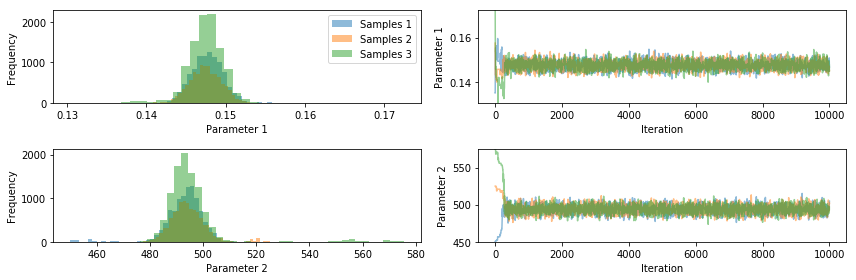

In [32]:
pints.plot.trace(chains)
plt.show()

In [33]:
chain = chains[0]

emu_prediction = np.apply_along_axis(emu_nn, 1, chain).flatten()
real_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

diffs = np.abs(real_prediction - emu_prediction)

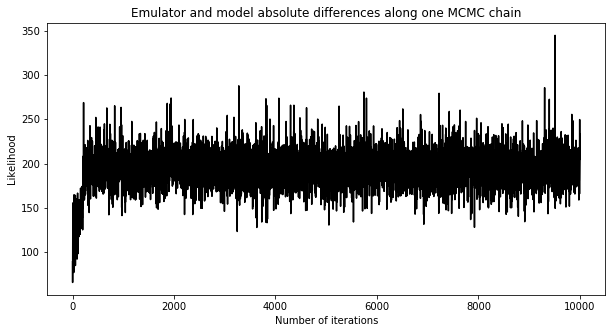

In [34]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along one MCMC chain")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()